In [1]:
import pandas as pd
# import numpy as np
# import array_api_strict as np
import array_api_compat.numpy as np 
## import data set
data = pd.read_csv('train.csv')
## Data shuffle
data = data.sample(frac=1)
tmp = pd.DataFrame()

## 600 entries per class
mid = int(data.shape[0] / 2)
data_first_half = data.iloc[:mid]
data_second_half = data.iloc[mid:]

# Function to get a balanced subset of data with 'n_samples' for each label
def get_balanced_data(df, n_samples):
    return pd.concat([df[df['label'] == label].head(n_samples) for label in range(10)])

# Get 600 data points for each label from the first half
data_balanced = get_balanced_data(data_first_half, 600)

# Get 100 data points for each label from the second half
data_test = get_balanced_data(data_second_half, 100)

print(data_test.shape)
print(data_balanced.shape)

(1000, 785)
(6000, 785)


In [2]:
def flatten_to_image(data, image_height=28, image_width=28):
    """
    Convert flattened input data into image format.

    Parameters:
    - data: pandas DataFrame, the dataset with flattened images.
    - image_height: int, the height of the images after reshaping.
    - image_width: int, the width of the images after reshaping.

    Returns:
    - numpy array of shape (N, 1, image_height, image_width), where N is the number of data points.
    """
    # Drop the 'label' column and convert to numpy array
    image_data = np.asarray(data.drop('label', axis=1), dtype=np.float32)
    
    # Reshape data into (N, 1, 28, 28) format
    data_array = np.reshape(image_data, (-1, 1, image_height, image_width)) / 255.0
    
    return data_array

# Shuffle and convert both training and testing data
data_balanced = data_balanced.sample(frac=1)
data_array = flatten_to_image(data_balanced)

data_test = data_test.sample(frac=1)
data_test_input = flatten_to_image(data_test)

print(data_array.shape)
print(data_test_input.shape)

(6000, 1, 28, 28)
(1000, 1, 28, 28)


In [3]:
def labels_to_one_hot(labels, size, num_classes=10):
    """
    Convert a list of numeric labels into one-hot encoded format.

    Parameters:
    - labels: list or numpy array, the list of labels to be converted.
    - num_classes: int, the number of unique classes.

    Returns:
    - A numpy array representing the one-hot encoded labels.
    """
    # Initialize the one-hot encoding array with zeros
    one_hot_encoding = np.asarray(np.zeros((size, num_classes)))
    
    # Use numpy indexing to set elements to 1
    # one_hot_encoding[np.arange(size), labels] = 1
    for idx, label in enumerate(labels):
        one_hot_encoding[idx, label] = 1
    
    return one_hot_encoding

# Convert 'label' column from the balanced data to a list
labels = data_balanced['label']
size = len(labels)
labels = list(labels)
labels = np.asarray(labels)
print(labels)
# Labels --> one hot

one_hot_encoding = labels_to_one_hot(labels, size)
print(one_hot_encoding)

[8 5 9 ... 6 6 0]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


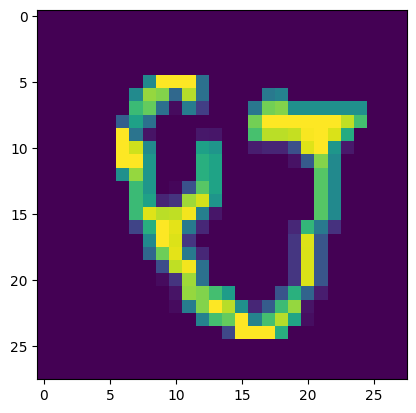

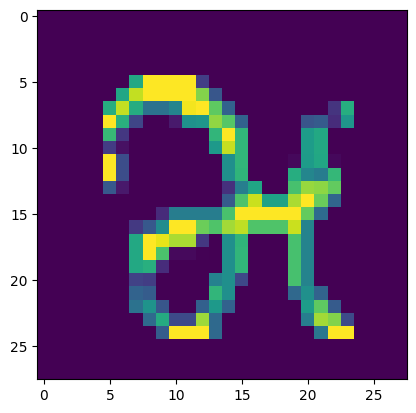

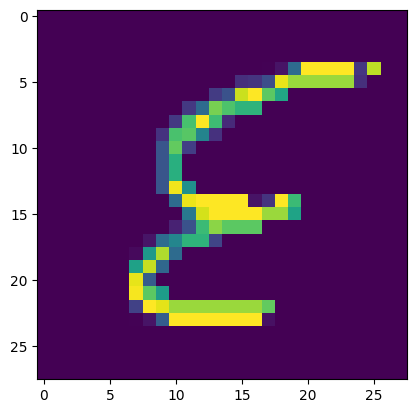

In [4]:
import matplotlib.pyplot as plt

for i in range(3):
    plt.imshow(data_array[i,0,:,:])
    plt.pause(0.5)

In [5]:
def im2col(X, conv1, stride, pad):
    # Dims of the input
    num_images, num_channels, input_height, input_width = X.shape
    filter_height, filter_width = conv1.shape[2], conv1.shape[3]

    # Dims of the output post-filter
    output_height = (input_height - filter_height + 2 * pad) // stride + 1
    output_width = (input_width - filter_width + 2 * pad) // stride + 1

    # Arr for unique transformed matrix
    im2col_vector = np.zeros((num_channels * filter_height * filter_width, output_width * output_height * num_images))

    col_idx = 0  # Current column in the output array

    # Iterate over each image in the batch
    for i in range(num_images):
        # Current image
        image = X[i, :, :, :]
        
        # Slide filter over the image, considering the padding
        for y in range(-pad, input_height - filter_height + pad + 1, stride):
            for x in range(-pad, input_width - filter_width + pad + 1, stride):
                # Initialize a matrix to hold the unrolled filter region
                filter_region = np.zeros((num_channels, filter_height, filter_width))
                
                # Calculate the start and end points on the original image
                y_start, x_start = max(0, y), max(0, x)
                y_end, x_end = min(input_height, y + filter_height), min(input_width, x + filter_width)

                # Calculate the start and end points on the filter region
                filter_y_start, filter_x_start = max(0, -y), max(0, -x)
                filter_y_end, filter_x_end = filter_y_start + (y_end - y_start), filter_x_start + (x_end - x_start)

                # Copy the valid parts of the image to the filter region
                filter_region[:, filter_y_start:filter_y_end, filter_x_start:filter_x_end] = \
                    image[:, y_start:y_end, x_start:x_end]

                # Flatten and store in im2col_vector
                # print(np.reshape(filter_region, -1))
                im2col_vector[:, col_idx:col_idx + 1] = np.reshape(filter_region, (-1, 1))
                col_idx += 1

    return im2col_vector

# Usage
# X is your input data array: shape (num_images, channels, height, width)
# conv1 is your filter array: shape (num_output_channels, input_channels, filter_height, filter_width)
# stride and pad are integers

In [6]:
# def im2col(X, conv1, stride, pad):
#     # Pad around images to preserve size after convolution
#     X_padded = np.pad(X, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant')
#     X = X_padded
    
#     # Dims of the output post-filter
#     new_height = int((X.shape[2] - conv1.shape[2]) / stride) + 1
#     new_width = int((X.shape[3] - conv1.shape[3]) / stride) + 1
    
#     # Arr for unique transformed matrix
#     im2col_vector = np.zeros((X.shape[1] * conv1.shape[2] * conv1.shape[3], new_width * new_height * X.shape[0]))
#     c = 0  # Curr column in the output array
    
#     # Iterate over each image in the batch
#     for position in range(X.shape[0]):
#         # Current image
#         image_position = X[position, :, :, :]
        
#         # Vertical slide down the image, with "stride" steps 
#         for height in range(0, image_position.shape[1], stride):
#             # Select a horizontal slice that matches filter height
#             image_rectangle = image_position[:, height:height + conv1.shape[2], :]
#             # Next iteration if slice's height < than filter height
#             if image_rectangle.shape[1] < conv1.shape[2]:
#                 continue
            
#             # Horizontal slide down the image, with "stride" steps 
#             for width in range(0, image_rectangle.shape[2], stride):
#                 # Slice portion that matches the filter width
#                 image_square = image_rectangle[:, :, width:width + conv1.shape[3]]
#                 # If portion's width < filter width
#                 if image_square.shape[2] < conv1.shape[3]:
#                     continue
                
#                 # Flatten and store 
#                 im2col_vector[:, c:c + 1] = image_square.reshape(-1, 1)
#                 c += 1
 
#     return im2col_vector


In [7]:
X_batch = data_array[0:10,:,:,:]
import math
import random

conv1 = [[[[random.gauss(0, 1) for _ in range(5)]
           for _ in range(5)]
          for _ in range(1)]
         for _ in range(2)]
conv1 = np.asarray(conv1)
X_im2col = im2col(X=X_batch,conv1=conv1,stride=1,pad=0)
conv1_reshaped = np.reshape(conv1, (conv1.shape[0],-1))
X_conv = conv1_reshaped@X_im2col
# print(X_conv,X_batch.shape[0])
#print(np.hsplit(X_conv,X_batch.shape[0]))
X_conv = np.asarray(X_conv)
X_conv = np.reshape(X_conv, (X_batch.shape[0], conv1.shape[0], 24, 24))
print(X_conv.shape)

(10, 2, 24, 24)


In [8]:
def ReLU(x):
    return (x > 0) * x

def softmax(x):
    x_exp = np.exp(x-np.max(x))
    return x_exp/np.sum(x_exp,axis=0)

def maxpool_multiple(input_image, stride=2):
    # This function applies max pooling to a batch of images with a specified stride.
    # Calculate the dimensions of the output image
    input_width = input_image.shape[3]
    input_height = input_image.shape[2]
    filter_width = 2
    filter_height = 2
    
    output_width = int((input_width - filter_width) / stride) + 1
    output_height = int((input_height - filter_height) / stride) + 1
    
    # Initialize the output image array with zeros
    output_image = np.zeros((input_image.shape[0], input_image.shape[1], output_height, output_width))
    # Apply max pooling to each image in the batch
    for i in range(output_image.shape[0]):
        output_image[i:i+1, :, :, :] = maxpool(input_image[i:i+1, :, :, :], stride=2)
    return output_image

def maxpool(input_image, stride=2):
    # Apply max pooling to a single image with a specified stride and 2x2 pooling filter.
    input_width = input_image.shape[3]
    input_height = input_image.shape[2]
    filter_width = 2
    filter_height = 2
    n_channels = input_image.shape[1]
    num_images = input_image.shape[0]
    
    # Output dims
    output_width = int((input_width - filter_width) / stride) + 1
    output_height = int((input_height - filter_height) / stride) + 1
    
    # Initialize the output array with zeros
    output = np.zeros((n_channels, output_width * output_height))
    c = 0      
    # Iteration over input image height
    for height in range(0, input_height, stride):
        if height + filter_height <= input_height:
            # Vertical slice of the image
            image_rectangle = input_image[0, :, height:height + filter_height, :]
            # Width of the input image
            for width in range(0, input_width, stride):
                if width + filter_width <= input_width:
                    # Square portion of the image
                    image_square = image_rectangle[:, :, width:width + filter_width]
                    # Flattened square portion and max pool
                    image_flatten = image_square.reshape(-1, 1)
                    output[:, c:c + 1] = np.array([float(max(i.ravel())) for i in np.split(image_flatten, n_channels)]).reshape(-1, 1)
                    c += 1
   
    # Reshape output to match the expected
    final_output = np.array(np.hsplit(output, 1)).reshape((1, n_channels, output_height, output_width))
        
    return final_output


In [9]:
def dReLU(x):
    return (x>0)*1.0

def maxpool_indices(input_image,stride=2,filter_height=2, filter_width=2):
    positional_vector = []
    for channel in range(input_image.shape[1]):
        x = -1 # output height counter

        # Curr channel
        chosen_image_channel = input_image[:,channel,:,:]
        # Through height with stride
        for height in range(0,chosen_image_channel.shape[1],stride):
            if height+stride<=chosen_image_channel.shape[1]:
                # Horizontal slice
                image_rectangle = chosen_image_channel[:,height:height+filter_height,:]
                x = x+1
                y = -1 # output width counter
                # Go through slide width with stride
                for width in range(0,image_rectangle.shape[2],stride):
                    if width+stride<= image_rectangle.shape[2]:
                        y = y+1
                        # Square portion
                        image_square = image_rectangle[:,:,width:width+filter_width]
                        # Max val within square 
                        a,b,c = np.unravel_index(image_square.argmax(),image_square.shape)
                        # Store map and max val
                        positional_vector.append([0,channel,int(b)+height,int(c)+width,0,channel,x,y])
    return positional_vector

def maxpool_indices_multiple(input_image,stride=2,filter_height=2, filter_width=2):
    positional_vector =[]
    # Go through each image
    for i in range(input_image.shape[0]):
        # Add vector of maxpool idx to curr image
        positional_vector.append(maxpool_indices(input_image[i:i+1,:,:,:],stride=2,filter_height=2,filter_width=2))
    return positional_vector

In [10]:
def error_layer_reshape(error_layer):
    test_array = error_layer
    # New arr for reshaped data with flattened dims
    # New shape is determined by channels (second dimension) and a flattened version of the remaining dimensions
    test_array_new = np.zeros((test_array.shape[1], test_array.shape[0] * test_array.shape[2] * test_array.shape[3]))
    
    # Go through each channel to reshape and flatten the error data
    for i in range(test_array_new.shape[0]):
        # Flatten each channel's error data and store it
        test_array_new[i:i + 1, :] = np.reshape(test_array[:, i:i + 1, :, :], -1)
        
    return test_array_new

In [11]:
X_batch_im2col = im2col(X=X_batch,conv1=conv1, stride=1, pad=0)
delta_conv = [[[[
    random.random() for _ in range(24)
] for _ in range(24)] for _ in range(2)] for _ in range(10)]
delta_conv = np.asarray(delta_conv)
delta_conv_reshape = error_layer_reshape(delta_conv)
print(delta_conv_reshape.shape)
conv1_delta = np.reshape((delta_conv_reshape@X_batch_im2col.T),(2,1,5,5))
print(conv1_delta.shape)

(2, 5760)
(2, 1, 5, 5)


In [12]:
# import array_api_strict as np
import array_api_compat.numpy as np

data_arr = np.zeros((10,10))

slice = np.asarray([1,2])

data_slice = data_arr[slice,:]

In [16]:
# !python -m pip install array-api-compat
import array_api_compat.numpy as np
'''Simple Architecture for Recognition

1) (1,1,28,28)
2) Convolution filter (2,1,5,5)
3) (Max Pool 2x2)
4) Fc layer (1,288)
5) Second FC (1,60)
6) Output Layer(1,10)

'''

epochs = 10
batch_size = 32
batches = int(data_array.shape[0]/batch_size)

conv1 = [[[[
    random.random() for _ in range(5)
] for _ in range(5)] for _ in range(1)] for _ in range(2)]
conv1 = np.asarray(conv1, dtype=np.float32)
conv1 = conv1*math.sqrt(0.2)
W1in = [[random.random() for _ in range(288)] for _ in range(60)]
W1in = np.asarray(W1in, dtype=np.float32)
W1 = W1in/math.sqrt(288)
B0 = np.zeros((60,1))/math.sqrt(288)
W2in = [[random.random() for _ in range(60)] for _ in range(10)]
W2in = np.asarray(W2in, dtype=np.float32)
W2 = W2in/math.sqrt(60)
B1 = np.zeros((10,1))/math.sqrt(60)
learning_rate = 0.001
## Implementing Adam Optimizer

beta1 = 0.9
beta2 = 0.995
momentum_w1 = 0
momentum_w2 = 0
momentum_b0 = 0
momentum_b1 = 0
momentum_conv1 = 0
velocity_w1 = 0
velocity_w2 = 0
velocity_b0 = 0
velocity_b1 = 0
velocity_conv1 = 0
for epoch_num in range(epochs):
    
    '''
    Choose chunks of data based on batch size  
    '''
    i = 0
    indices = list(range(data_array.shape[0]))
    random.shuffle(indices)
    permutation = np.asarray(indices)
    # copy each dimension/index i into data_array_train (allocate for both onehot/data array)
    # data_array_train = data_array[permutation,...]
    data_array_train = data_array[permutation,:,:,:]
    one_hot_encoding_train = one_hot_encoding[permutation,...]
    for i in range(batches):
        start = i*batch_size
        end = min(start+batch_size,data_array.shape[0]-1)
        X_batch = data_array_train[start:end,:,:,:]
        y_batch = one_hot_encoding_train[start:end,:].T
        ### First Convolutional Layer
        #X_conv = conv2dim2col_multiple(input_image=X_batch,conv_filter=conv1,stride=1)
        X_im2col = im2col(X=X_batch,conv1=conv1,stride=1,pad=0)
        conv1_reshaped = conv1.reshape(conv1.shape[0],-1)
        X_conv = conv1_reshaped@X_im2col
        X_conv = X_conv.reshape(32, 2, 24, 24) 
        
        ### Pass through ReLU
        
        X_relu = ReLU(X_conv)
        
        ### Pass Through Max Pool
        
        X_maxpool = maxpool_multiple(X_relu,stride=2)
        
        ### Get the indices of maxpool
        
        max_indices = maxpool_indices_multiple(X_relu,stride=2,filter_height=2, filter_width=2)
        
        ### Flatten the maxpool output
        input_shape, num_channels, input_width, input_height = X_maxpool.shape
        X_maxpool_flatten= np.zeros((input_width*input_height*num_channels,input_shape))
        for image in range(input_shape):
            X_maxpool_flatten[:,image:image+1] = X_maxpool[image:image+1,:,:,:].ravel().reshape(-1,1)
        
        ### Getting into fully connected layers
        fc1 = ReLU(W1@X_maxpool_flatten+B0)
        final_fc = softmax(W2@fc1+B1)
        # print('Sum of Final FC')
        # print(np.sum(final_fc))
        # print(final_fc)
#         break
        # print('Loss:')
        # print(cross_entropy(y=y_batch,y_hat=final_fc))

        ### Calculating Loss Through Backprop
        
        delta_2 = (final_fc-y_batch)
        delta_1 = np.multiply(W2.T@delta_2,dReLU(W1@X_maxpool_flatten+B0))
        delta_0 = np.multiply(W1.T@delta_1,1.0)
        
        dW1 = delta_1@X_maxpool_flatten.T
        dW2 = delta_2@fc1.T
        dB0 = np.sum(delta_1,axis=1,keepdims=True)
        dB1 = np.sum(delta_2,axis=1,keepdims=True)
        # print('Delta 2')
        # print(delta_2)
        
        ### Calculating Error for Last Layer before flattening
        
        delta_maxpool = delta_0.reshape(X_maxpool.shape)
        
        ### Calculating Error for previous convolutional layer
        
        delta_conv = np.zeros(X_conv.shape)
        for image in range(len(max_indices)):
            indices = max_indices[image]
            for p in indices:
                delta_conv[image:image+1,p[1],p[2],p[3]] = delta_maxpool[image:image+1,p[5],p[6],p[7]]
        delta_conv = np.multiply(delta_conv,dReLU(X_conv))
        
        ### using Im2col
        X_batch_im2col = im2col(X=X_batch,conv1=conv1, stride=1, pad=0)
        delta_conv_reshape = error_layer_reshape(delta_conv)
        conv1_delta = (delta_conv_reshape@X_batch_im2col.T).reshape(2,1,5,5)
        
        momentum_w1 = beta1*momentum_w1 + ((1-beta1)*dW1)
        momentum_w2 = beta1*momentum_w2 + ((1-beta1)*dW2)
        momentum_b0 = beta1*momentum_b0 + ((1-beta1)*dB0)
        momentum_b1 = beta1*momentum_b1 + ((1-beta1)*dB1)
        momentum_conv1 = beta1*momentum_conv1 + ((1-beta1)*conv1_delta)
        velocity_w1 = beta2*velocity_w1 + ((1-beta2)*dW1**2)
        velocity_w2 = beta2*velocity_w2 + ((1-beta2)*dW2**2)
        velocity_b0 = beta2*velocity_b0 + ((1-beta2)*dB0**2)
        velocity_b1 = beta2*velocity_b1 + ((1-beta2)*dB1**2)
        velocity_conv1 = beta2*velocity_conv1 + ((1-beta2)*conv1_delta**2)
        
        
        #conv1_delta = conv_filter_error_multiple(input_image=X_batch,error_layer=delta_conv,conv_filter=conv1,stride=1)
        #print('conv1 delta done')
        ## Update Weights
        epsilon = 1e-6
        conv1 = conv1 - learning_rate * momentum_conv1/np.sqrt(velocity_conv1+epsilon)
        W1 = W1 - learning_rate*momentum_w1/np.sqrt(velocity_w1+epsilon)
        W2 = W2 - learning_rate*momentum_w2/np.sqrt(velocity_w2+epsilon)
        B0 = B0 - learning_rate*momentum_b0/np.sqrt(velocity_b0+epsilon)
        B1 = B1 - learning_rate*momentum_b1/np.sqrt(velocity_b1+epsilon)
        #print('Back Prop Done!')
        #i+=1
    
    X = data_array
    y = one_hot_encoding.T
    X_im2col = im2col(X=X,conv1=conv1,stride=1,pad=0)
    conv1_reshaped = conv1.reshape(conv1.shape[0],-1)
    X_conv = conv1_reshaped@X_im2col
    X_conv = np.array(np.hsplit(X_conv,X.shape[0])).reshape((X.shape[0],conv1.shape[0],24,24))
        
        
    ### Pass through ReLU
        
    X_relu = ReLU(X_conv)
        
    ### Pass Through Max Pool
        
    X_maxpool = maxpool_multiple(X_relu,stride=2)
    input_shape = X_maxpool.shape[0]
    num_channels = X_maxpool.shape[1]
    input_width = X_maxpool.shape[2]
    input_height = X_maxpool.shape[3]
    X_maxpool_flatten= np.zeros((input_width*input_height*num_channels,input_shape))
    for image in range(input_shape):
        X_maxpool_flatten[:,image:image+1] = X_maxpool[image:image+1,:,:,:].reshape(-1,1)  
    ### Getting into fully connected layers
    fc1 = ReLU(W1@X_maxpool_flatten+B0)
    final_fc = softmax(W2@fc1+B1)
    
    #### Test Data
    X = data_test_input
    #y = one_hot_encoding.T
    X_im2col = im2col(X=X,conv1=conv1,stride=1,pad=0)
    conv1_reshaped = conv1.reshape(conv1.shape[0],-1)
    X_conv = conv1_reshaped@X_im2col
    X_conv = np.array(np.hsplit(X_conv,X.shape[0])).reshape((X.shape[0],conv1.shape[0],24,24))
        
        
    ### Pass through ReLU
        
    X_relu = ReLU(X_conv)
        
    ### Pass Through Max Pool
        
    X_maxpool = maxpool_multiple(X_relu,stride=2)
    input_shape = X_maxpool.shape[0]
    num_channels = X_maxpool.shape[1]
    input_width = X_maxpool.shape[2]
    input_height = X_maxpool.shape[3]
    X_maxpool_flatten= np.zeros((input_width*input_height*num_channels,input_shape))
    for image in range(input_shape):
        X_maxpool_flatten[:,image:image+1] = X_maxpool[image:image+1,:,:,:].reshape(-1,1)  
    ### Getting into fully connected layers
    fc1 = ReLU(W1@X_maxpool_flatten+B0)
    final_fc_test = softmax(W2@fc1+B1)
    
    
    
    
    if epoch_num % 1  == 0:
        ### Getting accuracy
        print('Epoch :', (epoch_num + 1))
        labels_predict = np.argmax(final_fc,axis=0)
        labels_df  = data_balanced[['label']]
        labels_predict = labels_predict.tolist()
        labels_predict = [int(value) for value in labels_predict]
        #labels_df.loc[:,'label_predict'] = labels_predict
        labels_df.insert(1,'label_predict',labels_predict)
        accuracy = np.sum(labels_df['label']==labels_df['label_predict'])/labels_df.shape[0]
        print('Train Accuracy')
        print(round(accuracy*100,2),"%")
        
        ### Test Accuracy
        
        labels_predict = np.argmax(final_fc_test,axis=0)
        labels_df  = data_test[['label']]
        labels_predict = labels_predict.tolist()
        labels_predict = [int(value) for value in labels_predict]
        labels_df.insert(1,'label_predict',labels_predict)
        #labels_df.loc[:,'label_predict'] = labels_predict
        accuracy = np.sum(labels_df['label']==labels_df['label_predict'])/labels_df.shape[0]
        print('Test Accuracy')
        print(round(accuracy*100,2),"%")
        print('-------------------------')
        
#       print(cross_entropy(y=y,y_hat=final_fc))
    

Epoch : 1
Train Accuracy
31.65 %
Test Accuracy
32.1 %
-------------------------
Epoch : 2
Train Accuracy
34.57 %
Test Accuracy
34.7 %
-------------------------
Epoch : 3
Train Accuracy
47.65 %
Test Accuracy
44.9 %
-------------------------
Epoch : 4
Train Accuracy
41.23 %
Test Accuracy
41.1 %
-------------------------
Epoch : 5
Train Accuracy
56.23 %
Test Accuracy
56.4 %
-------------------------
Epoch : 6
Train Accuracy
60.88 %
Test Accuracy
61.6 %
-------------------------
Epoch : 7
Train Accuracy
52.62 %
Test Accuracy
53.3 %
-------------------------
Epoch : 8
Train Accuracy
58.25 %
Test Accuracy
60.4 %
-------------------------
Epoch : 9
Train Accuracy
40.6 %
Test Accuracy
40.1 %
-------------------------
Epoch : 10
Train Accuracy
37.55 %
Test Accuracy
36.7 %
-------------------------


In [ ]:
def update_with_adam(parameters, grads, velocities, momentums, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Update parameters using Adam optimization algorithm.

    parameters - Dictionary containing your parameters:
                  parameters['W1'], parameters['B0'], parameters['W2'], parameters['B1'], parameters['Conv1']
    grads - Dictionary containing your gradients for each parameters
    velocities - Dictionary containing the exponentially weighted average of the squared gradient
    momentums - Dictionary containing the exponentially weighted average of the gradient
    t - Epoch number
    """
    L = len(parameters) // 2  # Number of layers in the neural network
    
    for l in range(L):
        # Moving average of the gradients.
        momentums['dW' + str(l+1)] = beta1 * momentums.get('dW' + str(l+1), np.zeros_like(grads['dW' + str(l+1)])) + (1 - beta1) * grads['dW' + str(l+1)]
        momentums['dB' + str(l)] = beta1 * momentums.get('dB' + str(l), np.zeros_like(grads['dB' + str(l)])) + (1 - beta1) * grads['dB' + str(l)]

        # Compute bias-corrected first moment estimate.
        mt_dW = momentums['dW' + str(l+1)] / (1 - np.power(beta1, t))
        mt_dB = momentums['dB' + str(l)] / (1 - np.power(beta1, t))

        # Moving average of the squared gradients.
        velocities['dW' + str(l+1)] = beta2 * velocities.get('dW' + str(l+1), np.zeros_like(grads['dW' + str(l+1)])) + (1 - beta2) * np.square(grads['dW' + str(l+1)])
        velocities['dB' + str(l)] = beta2 * velocities.get('dB' + str(l), np.zeros_like(grads['dB' + str(l)])) + (1 - beta2) * np.square(grads['dB' + str(l)])

        # Compute bias-corrected second raw moment estimate.
        vt_dW = velocities['dW' + str(l+1)] / (1 - np.power(beta2, t))
        vt_dB = velocities['dB' + str(l)] / (1 - np.power(beta2, t))

        # Update parameters.
        parameters['W' + str(l+1)] -= learning_rate * mt_dW / (np.sqrt(vt_dW) + epsilon)
        parameters['B' + str(l)] -= learning_rate * mt_dB / (np.sqrt(vt_dB) + epsilon)

    # Convolution layer update
    momentums['Conv1'] = beta1 * momentums.get('Conv1', np.zeros_like(parameters['Conv1'])) + (1 - beta1) * grads['dConv1']
    mt_Conv1 = momentums['Conv1'] / (1 - np.power(beta1, t))
    velocities['Conv1'] = beta2 * velocities.get('Conv1', np.zeros_like(parameters['Conv1'])) + (1 - beta2) * np.square(grads['dConv1'])
    vt_Conv1 = velocities['Conv1'] / (1 - np.power(beta2, t))
    parameters['Conv1'] -= learning_rate * mt_Conv1 / (np.sqrt(vt_Conv1) + epsilon)

    return parameters, velocities, momentums

In [ ]:
def initialize_parameters_and_optimizers():
    params = {
        'conv1': np.random.randn(2, 1, 5, 5) * np.sqrt(1. / 5.),
        'W1': np.random.rand(60, 288) / np.sqrt(288),
        'B0': np.zeros((60, 1)) / np.sqrt(288),
        'W2': np.random.rand(10, 60) / np.sqrt(60),
        'B1': np.zeros((10, 1)) / np.sqrt(60)
    }
    momentums = {key: np.zeros_like(value) for key, value in params.items()}
    velocities = {key: np.zeros_like(value) for key, value in params.items()}
    return params, momentums, velocities


In [ ]:
'''Simple Architecture for Recognition

1) (1,1,28,28)
2) Convolution filter (2,1,5,5)
3) (Max Pool 2x2)
4) Fc layer (1,288)
5) Second FC (1,60)
6) Output Layer(1,10)

'''

epochs = 10
batch_size = 32
batches = int(data_array.shape[0]/batch_size)

# Initialize parameters and optimizers
parameters, momentums, velocities = initialize_parameters_and_optimizers()
beta1 = 0.9
beta2 = 0.995
for epoch_num in range(epochs):
    
    '''
    Choose chunks of data based on batch size  
    '''
    i = 0
    permutation = np.random.permutation(data_array.shape[0])
    data_array_train = data_array[permutation,:,:,:]
    one_hot_encoding_train = one_hot_encoding[permutation,:]
    for i in range(batches):
        start = i*batch_size
        end = min(start+batch_size,data_array.shape[0]-1)
        X_batch = data_array_train[start:end,:,:,:]
        y_batch = one_hot_encoding_train[start:end,:].T
        ### First Convolutional Layer
        #X_conv = conv2dim2col_multiple(input_image=X_batch,conv_filter=conv1,stride=1)
        X_im2col = im2col(X=X_batch, conv1=parameters['conv1'], stride=1, pad=0)
        conv1_reshaped = parameters['conv1'].reshape(parameters['conv1'].shape[0], -1)
        X_conv = conv1_reshaped@X_im2col
        X_conv = np.array(np.hsplit(X_conv,X_batch.shape[0])).reshape((X_batch.shape[0],conv1.shape[0],24,24))
        
        ### Pass through ReLU
        
        X_relu = ReLU(X_conv)
        
        ### Pass Through Max Pool
        
        X_maxpool = maxpool_multiple(X_relu,stride=2)
        
        ### Get the indices of maxpool
        
        max_indices = maxpool_indices_multiple(X_relu,stride=2,filter_height=2, filter_width=2)
        
        ### Flatten the maxpool output
        input_shape, num_channels, input_width, input_height = X_maxpool.shape
        X_maxpool_flatten= np.zeros((input_width*input_height*num_channels,input_shape))
        for image in range(input_shape):
            X_maxpool_flatten[:,image:image+1] = X_maxpool[image:image+1,:,:,:].ravel().reshape(-1,1)
        
        ### Getting into fully connected layers
        fc1 = ReLU(W1@X_maxpool_flatten+B0)
        final_fc = softmax(W2@fc1+B1)
        # print('Sum of Final FC')
        # print(np.sum(final_fc))
        # print(final_fc)
#         break
        # print('Loss:')
        # print(cross_entropy(y=y_batch,y_hat=final_fc))

        ### Calculating Loss Through Backprop
        
        delta_2 = (final_fc-y_batch)
        delta_1 = np.multiply(W2.T@delta_2,dReLU(W1@X_maxpool_flatten+B0))
        delta_0 = np.multiply(W1.T@delta_1,1.0)
        
        dW1 = delta_1@X_maxpool_flatten.T
        dW2 = delta_2@fc1.T
        dB0 = np.sum(delta_1,axis=1,keepdims=True)
        dB1 = np.sum(delta_2,axis=1,keepdims=True)
        # print('Delta 2')
        # print(delta_2)
        
        ### Calculating Error for Last Layer before flattening
        
        delta_maxpool = delta_0.reshape(X_maxpool.shape)
        
        ### Calculating Error for previous convolutional layer
        
        delta_conv = np.zeros(X_conv.shape)
        for image in range(len(max_indices)):
            indices = max_indices[image]
            for p in indices:
                delta_conv[image:image+1,p[1],p[2],p[3]] = delta_maxpool[image:image+1,p[5],p[6],p[7]]
        delta_conv = np.multiply(delta_conv,dReLU(X_conv))
        
        ### using Im2col
        X_batch_im2col = im2col(X=X_batch,conv1=conv1, stride=1, pad=0)
        delta_conv_reshape = error_layer_reshape(delta_conv)
        conv1_delta = (delta_conv_reshape@X_batch_im2col.T).reshape(2,1,5,5)
        
        # Define dictionaries for parameters and gradients
        parameters = {'W1': W1, 'B0': B0, 'W2': W2, 'B1': B1, 'Conv1': conv1}
        grads = {'dW1': dW1, 'dB0': dB0, 'dW2': dW2, 'dB1': dB1, 'dConv1': conv1_delta}
        
        # Update parameters with Adam optimizer
        parameters, velocities, momentums = update_with_adam(parameters, grads, velocities, momentums, epoch_num+1, learning_rate, beta1, beta2, epsilon)

        # Extract updated parameters
        W1, B0, W2, B1, conv1 = parameters['W1'], parameters['B0'], parameters['W2'], parameters['B1'], parameters['Conv1']
        
        #conv1_delta = conv_filter_error_multiple(input_image=X_batch,error_layer=delta_conv,conv_filter=conv1,stride=1)
        #print('conv1 delta done')
        ## Update Weights
        epsilon = 1e-6
        conv1 = conv1 - learning_rate * momentum_conv1/np.sqrt(velocity_conv1+epsilon)
        W1 = W1 - learning_rate*momentum_w1/np.sqrt(velocity_w1+epsilon)
        W2 = W2 - learning_rate*momentum_w2/np.sqrt(velocity_w2+epsilon)
        B0 = B0 - learning_rate*momentum_b0/np.sqrt(velocity_b0+epsilon)
        B1 = B1 - learning_rate*momentum_b1/np.sqrt(velocity_b1+epsilon)
        #print('Back Prop Done!')
        #i+=1
    X = data_array
    y = one_hot_encoding.T
    X_im2col = im2col(X=X,conv1=conv1,stride=1,pad=0)
    conv1_reshaped = conv1.reshape(conv1.shape[0],-1)
    X_conv = conv1_reshaped@X_im2col
    X_conv = np.array(np.hsplit(X_conv,X.shape[0])).reshape((X.shape[0],conv1.shape[0],24,24))
        
        
    ### Pass through ReLU
        
    X_relu = ReLU(X_conv)
        
    ### Pass Through Max Pool
        
    X_maxpool = maxpool_multiple(X_relu,stride=2)
    input_shape = X_maxpool.shape[0]
    num_channels = X_maxpool.shape[1]
    input_width = X_maxpool.shape[2]
    input_height = X_maxpool.shape[3]
    X_maxpool_flatten= np.zeros((input_width*input_height*num_channels,input_shape))
    for image in range(input_shape):
        X_maxpool_flatten[:,image:image+1] = X_maxpool[image:image+1,:,:,:].reshape(-1,1)  
    ### Getting into fully connected layers
    fc1 = ReLU(W1@X_maxpool_flatten+B0)
    final_fc = softmax(W2@fc1+B1)
    
    #### Test Data
    X = data_test_input
    #y = one_hot_encoding.T
    X_im2col = im2col(X=X,conv1=conv1,stride=1,pad=0)
    conv1_reshaped = conv1.reshape(conv1.shape[0],-1)
    X_conv = conv1_reshaped@X_im2col
    X_conv = np.array(np.hsplit(X_conv,X.shape[0])).reshape((X.shape[0],conv1.shape[0],24,24))
        
        
    ### Pass through ReLU
        
    X_relu = ReLU(X_conv)
        
    ### Pass Through Max Pool
        
    X_maxpool = maxpool_multiple(X_relu,stride=2)
    input_shape = X_maxpool.shape[0]
    num_channels = X_maxpool.shape[1]
    input_width = X_maxpool.shape[2]
    input_height = X_maxpool.shape[3]
    X_maxpool_flatten= np.zeros((input_width*input_height*num_channels,input_shape))
    for image in range(input_shape):
        X_maxpool_flatten[:,image:image+1] = X_maxpool[image:image+1,:,:,:].reshape(-1,1)  
    ### Getting into fully connected layers
    fc1 = ReLU(W1@X_maxpool_flatten+B0)
    final_fc_test = softmax(W2@fc1+B1)
    
    
    
    
    if epoch_num % 1  == 0:
        ### Getting accuracy
        print('Epoch :', epoch_num + 1)
        labels_predict = np.argmax(final_fc,axis=0)
        labels_df  = data_balanced[['label']]
        labels_predict = labels_predict.tolist()
        labels_predict = [int(value) for value in labels_predict]
        #labels_df.loc[:,'label_predict'] = labels_predict
        labels_df.insert(1,'label_predict',labels_predict)
        accuracy = np.sum(labels_df['label']==labels_df['label_predict'])/labels_df.shape[0]
        print('Train Accuracy')
        print(round(accuracy*100,2),"%")
        
        ### Test Accuracy
        
        labels_predict = np.argmax(final_fc_test,axis=0)
        labels_df  = data_test[['label']]
        labels_predict = labels_predict.tolist()
        labels_predict = [int(value) for value in labels_predict]
        labels_df.insert(1,'label_predict',labels_predict)
        #labels_df.loc[:,'label_predict'] = labels_predict
        accuracy = np.sum(labels_df['label']==labels_df['label_predict'])/labels_df.shape[0]
        print('Test Accuracy')
        print(round(accuracy*100,2),"%")
        print('-------------------------')
        
#       print(cross_entropy(y=y,y_hat=final_fc))
    

KeyError: 'conv1'